# Calculate Orbit of Sgr in Simulation Galaxy

In [ ]:
import numpy as np
from galpy.potential import SCFPotential, scf_compute_coeffs_nbody, evaluateDensities,plotDensities
from galpy.potential import MWPotential2014, turn_physical_off,Potential
from galpy.util.conversion import time_in_Gyr,mass_in_msol
from galpy.util import plot
import galpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as apu
import py.SimPy as sp
import pickle
import tqdm

In [2]:
with open('/home/bennett/nbody/data/n_part_equil.txt','r') as f:
    Np= f.read()
Np= np.array(Np.split('\n')[1].split(','),dtype='int')

## Load or Calculate SCFPotential for three components of the disc

In [3]:
try:
    with open('data/snaps/equil_306_snap','rb') as f:
        snap= pickle.load(f)
except:
    fname='/epsen_data/scr/bennett/MyMW_1e9/MyMW_306.00000'
    snap= sp.Snapshot(fname,Np[0],hf=Np[1],df=Np[2],bf=Np[3],Nslice=10,frac=False,dt=0.0098)

In [4]:
snap._COM

array([-0.05452025, -0.00312657,  0.12537393])

In [5]:
snap.calc_potential()

In [ ]:
rmin=0.
rmax=1.5
nrs=21
zmin=-0.5
zmax=0.5
nzs=21

phi=3.1415
ncontours=[21,5,10]

Rs= np.linspace(rmin,rmax,nrs)
zs= np.linspace(zmin,zmax,nzs)
potRz= np.zeros((3,nrs,nzs))
potRzMW= np.zeros((3,nrs,nzs))
for k,p in enumerate(snap.pot):
    for ii in range(nrs):
        for jj in range(nzs):
            R,z= Rs[ii], zs[jj]
            potRz[k,ii,jj]= evaluateDensities(p,np.fabs(R),z,phi=phi,use_physical=False)
            potRzMW[k,ii,jj]= evaluateDensities(MWPotential2014[2-k],np.fabs(R),z,phi=phi,use_physical=False)

aspect=.75*(rmax-rmin)/(zmax-zmin)

xlab=r"$R/R_0$"
ylab=r"$z/R_0$"

fig,ax= plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,8))
for i in range(3):
    ax[1,i].imshow((potRz[i].T),cmap='Greys',extent=[rmin,rmax,zmin,zmax])
    ax[1,i].contour(Rs, zs, (potRz[i].T), ncontours[i], colors='black')
    ax[0,i].imshow((potRzMW[i].T),cmap='Greys',extent=[rmin,rmax,zmin,zmax])
    ax[0,i].contour(Rs, zs, (potRzMW[i].T), ncontours[i], colors='black')

fig.subplots_adjust(hspace=0.,wspace=0)



### Setup the dynamical friction

In [9]:
SgrPath= pd.read_pickle('/home/bennett/MWwSgrLambda065')
print(SgrPath.columns)

Index(['step', 'time', 'mass', 'x', 'y', 'z', 'vx', 'vy', 'vz'], dtype='object')


1038.904


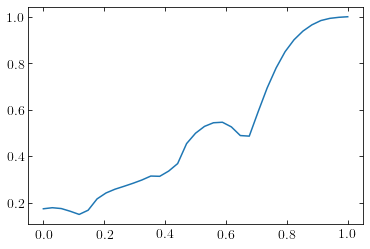

In [10]:
print(np.array(SgrPath['time'])[-1])
time_frac= SgrPath['time'][::-1]/np.array(SgrPath['time'])[-1]
massfrac_t= interp1d(time_frac,SgrPath['mass']/np.max(SgrPath['mass']),kind='cubic')

plt.plot(time_frac,massfrac_t(time_frac))

In [26]:
with open('/epsen_data/scr/bennett/Sgr-VerticalWaves/data/Orbits/vz_through.dat','rb') as f:
    vz= np.load(f)

idx0= np.argsort(vz)[0,0][len(vz[0,0])//2]
idx1= np.argsort(vz)[0,1][len(vz[0,1])//2]
idx2= np.argsort(vz)[0,2][len(vz[0,2])//2]

with open('/epsen_data/scr/bennett/Sgr-VerticalWaves/data/Orbits/dynfric/osgr_halo0_sgr0.pickle','rb') as f:
    o0= pickle.load(f)[idx0]
with open('/epsen_data/scr/bennett/Sgr-VerticalWaves/data/Orbits/dynfric/osgr_halo0_sgr1.pickle','rb') as f:
    o1= pickle.load(f)[idx1]
with open('/epsen_data/scr/bennett/Sgr-VerticalWaves/data/Orbits/dynfric/osgr_halo0_sgr2.pickle','rb') as f:
    o2= pickle.load(f)[idx2]
    
init= [o0.vxvv, o1.vxvv, o2.vxvv]
print(init)

[array([[ 2.08565863,  1.03271685,  0.29899307, -0.78285305,  0.91977612,
         2.9977595 ]]), array([[ 2.09925213,  1.01019162,  0.30403824, -0.78632461,  0.93162611,
         2.99806131]]), array([[ 2.09747526,  1.01377741,  0.30241442, -0.78587083,  0.93003155,
         2.99802208]])]


In [12]:
FilePath='/epsen_data/scr/bennett/WaveModel/'

with open(FilePath+'py/Data/halo_masses.dat','rb') as f:
    halo_m= np.loadtxt(f)
with open(FilePath+'py/Data/halo_radius.dat','rb') as f:
    halo_a= np.loadtxt(f)
with open(FilePath+'py/Data/stlr_masses.dat','rb') as f:
    stlr_m= np.loadtxt(f)
with open(FilePath+'py/Data/stlr_radius.dat','rb') as f:
    stlr_a= np.loadtxt(f)
with open(FilePath+'py/Data/sgr_rhm.dat','rb') as f:
    sgr_rhm= np.loadtxt(f)

nt=1001
sgrI=[0,1,2]

## Set up dynamical friction and integrate using SCF potential

In [14]:
chand_dynfric=[]
for ii in sgrI:
    chand_dynfric.append(galpy.potential.ChandrasekharDynamicalFrictionForce(amp=1.,
                                                                             GMs=(halo_m[ii]+stlr_m[ii])*apu.M_sun, 
                                                                             rhm=sgr_rhm[ii]*apu.kpc,
                                                                             dens=list(snap.pot)))
    chand_dynfric[ii].turn_physical_off()

In [27]:
# Now integrate
end_times=[-1.05,-0.98,-0.97]
r= np.zeros((3,nt-1))
sgr_final_loc= np.empty(3,dtype='object')
times = [np.linspace(0, end_times[ii], nt)/time_in_Gyr(220.,8.) for ii in sgrI]

for ii in sgrI:
    pot_df = snap.pot+chand_dynfric[ii]

    o_sgr = galpy.orbit.Orbit(vxvv=init[ii])
    o_sgr.turn_physical_off()

    for i in range(nt-1):
        pot_df[3].GMs= (halo_m[ii]+stlr_m[ii])*apu.M_sun*massfrac_t(times[ii][i]/times[ii][-1])
        t= np.linspace(times[ii][i],times[ii][(i+1)],100)
        o_sgr.integrate(t, pot_df)   
        r[ii,i]= o_sgr.r(times[ii][i+1])
        o_sgr= o_sgr(times[ii][(i+1)])
        sgr_final_loc[ii]= o_sgr

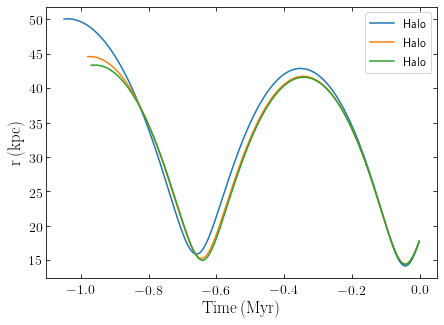

In [28]:
plt.figure(figsize=(7,5))
for ii in sgrI:
    plt.plot(times[ii][1:]*time_in_Gyr(220.,8.),r[ii]*8,label='Halo')
    plt.ylabel(r'$\mathrm{r\,(kpc)}$')
    plt.xlabel(r'$\mathrm{Time\,(Myr)}$')
    plt.legend()

In [34]:
with open('data/sgr_loc.txt','w') as f:
    f.write("x,y,z,vx,vy,vz\n")
    for ii in sgrI:
        f.write(str(sgr_final_loc[ii].x()[0]*8.)+','+str(sgr_final_loc[ii].y()[0]*8.)+','+
                str(sgr_final_loc[ii].z()[0]*8.)+','+str(sgr_final_loc[ii].vx()[0]*220.)+','+
                str(sgr_final_loc[ii].vy()[0]*220.)+','+str(sgr_final_loc[ii].vz()[0]*220.)+'\n')

In [3]:
with open('data/sgr_loc.txt','r') as f:
    Sgr_pos= f.read()

### Convert GalIC snapshot to binary file

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import struct
import ctypes
import pickle
import sys
import pygadgetreader

indx=0

#GalIC position units are 1 kpc
#GalIC velocity units are 1 km/s
#GalIC mass units are 10^10 Msun
dmx= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','pos',ptype='dm')
dmmask= tuple([np.sqrt(dmx[:,0]**2+dmx[:,1]**2+dmx[:,2]**2)<500.])
dmx= dmx[dmmask]
dmv= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','vel',ptype='dm')
dmv=dmv[dmmask]
dmm= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','mass',ptype='dm')*1e10
dmm= dmm[dmmask]

stlrx= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','pos',ptype='bulge')
stlrmask= tuple([np.sqrt(stlrx[:,0]**2+stlrx[:,1]**2+stlrx[:,2]**2)<500.])
stlrx= stlrx[stlrmask]
stlrv= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','vel',ptype='bulge')
stlrv= stlrv[stlrmask]
stlrm= pygadgetreader.readsnap('/epsen_data/scr/bennett/Sgr'+str(indx+1)+'/snap_010','mass',ptype='bulge')*1e10
stlrm= stlrm[stlrmask]

with open('/epsen_data/scr/bennett/MyMW_1e9/MyMW_306.00000','rb') as f:
    mw= np.fromfile(f,dtype='f4')
ntot= int(len(mw)/7)
mw= np.reshape(mw,[ntot,7])

nh=Np[1]
print(nh)

x,y,z,vx,vy,vz= [float(sgrxv.strip('[').strip(']')) for sgrxv in Sgr_pos.split('\n')[indx+1].split(',')]

xdark=np.hstack((mw[:nh,1],dmx[:,0]+x))
ydark=np.hstack((mw[:nh,2],dmx[:,1]+y))
zdark=np.hstack((mw[:nh,3],dmx[:,2]+z))
vxdark=np.hstack((mw[:nh,4],dmv[:,0]+vx))
vydark=np.hstack((mw[:nh,5],dmv[:,1]+vy))
vzdark=np.hstack((mw[:nh,6],dmv[:,2]+vz))
darkmass=np.hstack((mw[:nh,0],dmm))

xstar=np.hstack((mw[nh:,1],stlrx[:,0]+x))
ystar=np.hstack((mw[nh:,2],stlrx[:,1]+y))
zstar=np.hstack((mw[nh:,3],stlrx[:,2]+z))
vxstar=np.hstack((mw[nh:,4],stlrv[:,0]+vx))
vystar=np.hstack((mw[nh:,5],stlrv[:,1]+vy))
vzstar=np.hstack((mw[nh:,6],stlrv[:,2]+vz))
starmass=np.hstack((mw[nh:,0],stlrm))

del mw
del dmv,dmx,stlrv,stlrx,dmm,stlrm

nstar=len(starmass)
ngas=0
ndark=len(darkmass)

print(nstar,'stars')
print(ndark,'dark')

with open('data/n_part_Sgr'+str(indx+1)+'.txt','w') as f:
    f.write("total,halo,disc,bulge,Sgrhalo,SgrStlr\n")
    f.write(str(int(nstar+ndark))+','+str(int(ndark))+','+
            str(int(Np[2]))+','+str(int(Np[3]))+','+
            str(int(ndark-Np[1]))+','+str(int(nstar-Np[2]-Np[3])))

In [ ]:
f = open('/epsen_data/scr/bennett/IC4Jason/Morgan_Sgr'+str(indx+1)+'.tipsy', 'wb')
f.write(struct.pack("<diiiiii", 0.0, nstar+ndark, 3, 0, ndark, nstar, 2))
for i in range(ndark):
    f.write(struct.pack("<fffffffQ", darkmass[i]/2.324876e9, xdark[i], ydark[i], zdark[i], 
                        vxdark[i]/100., vydark[i]/100. ,vzdark[i]/100., np.int64(3000000000000000000+i)))
for i in range(nstar):
    f.write(struct.pack("<fffffffffQ", starmass[i]/2.324876e9, xstar[i], ystar[i], zstar[i], 
                        vxstar[i]/100., vystar[i]/100., vzstar[i]/100., 0.0, 0.0, np.int64(i)))
f.close()

In [ ]:
del vxstar,vystar,vzstar,zstar,starmass
del vxdark,vydark,vzdark,xdark,ydark,zdark,darkmass

In [ ]:
plt.hexbin(xstar,ystar,extent=[-50,50,-50,50],bins='log')

In [ ]:
del xstar,ystar